# ADS-508-01-SP23 Team 8: Final Project

# Setup Database Joins to Achieve the Analytics Base Table (ABT)

Much of the code is modified from `Fregly, C., & Barth, A. (2021). Data science on AWS: Implementing end-to-end, continuous AI and machine learning pipelines. O’Reilly.`

## Install missing dependencies

[PyAthena](https://pypi.org/project/PyAthena/) is a Python DB API 2.0 (PEP 249) compliant client for Amazon Athena.

In [2]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
!pip install missingno

## Globally import libraries

In [3]:
import boto3
from botocore.client import ClientError
import sagemaker
import pandas as pd
from pyathena import connect
from IPython.core.display import display, HTML
import missingno as msno
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import datetime as dt

%matplotlib inline

## Instantiate AWS SageMaker and S3 sessions

In [4]:
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
def_bucket = sagemaker_session.default_bucket()
bucket = 'sagemaker-us-east-ads508-sp23-t8'

s3 = boto3.Session().client(service_name="s3",
                            region_name=region)

In [5]:
print(f"Default bucket: {def_bucket}")
print(f"Public T8 bucket: {bucket}")

Default bucket: sagemaker-us-east-1-657724983756
Public T8 bucket: sagemaker-us-east-ads508-sp23-t8


## Query Athena Database

In [6]:
database_name = "ads508_t8"

In [7]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = f"s3://{def_bucket}/team_8_data/athena/staging"
print(s3_staging_dir)

s3://sagemaker-us-east-1-657724983756/team_8_data/athena/staging


In [8]:
conn = connect(region_name=region,
               s3_staging_dir=s3_staging_dir)

In [9]:
cen_tsv_tbl_name = 'census'
ceb_tsv_tbl_name = 'census_block'
evi_tsv_tbl_name = 'evictions'
cri_tsv_tbl_name = 'crime'
cri_pqt_tbl_name = 'crime_pqt'
grd_tsv_tbl_name = 'grad_outcomes'
hsi_tsv_tbl_name = 'hs_info'
job_tsv_tbl_name = 'jobs'

### Experiment with join using Athena

In [10]:
abt_select_to_join_stmnt01 = f"""
SELECT
    cen.censustract,
    cen.borough,
    cen.totalpop,
    cen.men,
    cen.women,
    cen.hispanic,
    cen.white,
    cen.black,
    cen.native,
    cen.asian,
    cen.citizen,
    cen.income,
    cen.poverty,
    cen.childpoverty,
    cen.professional,
    cen.service,
    cen.office,
    cen.construction,
    cen.production,
    cen.drive,
    cen.carpool,
    cen.transit,
    cen.walk,
    cen.othertransp,
    cen.workathome,
    cen.meancommute,
    cen.employed,
    cen.privatework,
    cen.publicwork,
    cen.selfemployed,
    cen.familywork,
    cen.unemployment,
    cvi.blockCode,
    cvi.eviction_count_x_lat_long
FROM {database_name}.{cen_tsv_tbl_name} AS cen
LEFT JOIN (
    SELECT
        ceb.blockCode AS blockCode,
        SUM(evi.eviction_count_x_lat_long) AS eviction_count_x_lat_long
    FROM (
        SELECT
            SUBSTR(blockCode,1,11) AS blockCode,
            COUNT(*),
            MIN(latitude) AS min_lat,
            MAX(latitude) AS max_lat,
            MIN(longitude) AS min_long,
            MAX(longitude) AS max_long     
        FROM {database_name}.{ceb_tsv_tbl_name}
        GROUP BY SUBSTR(blockCode,1,11)
        ORDER BY COUNT(*) DESC
        ) AS ceb
    INNER JOIN (
        SELECT
            CAST(latitude AS DOUBLE) AS latitude,
            CAST(longitude AS DOUBLE) AS longitude,
            COUNT(*) AS eviction_count_x_lat_long
        FROM {database_name}.{evi_tsv_tbl_name}
        WHERE latitude != ''
        GROUP BY latitude, longitude
        ORDER BY COUNT(*) DESC
        ) AS evi
    ON evi.latitude >= ceb.min_lat
        AND evi.latitude <= ceb.max_lat
        AND evi.longitude >= ceb.min_long
        AND evi.longitude <= ceb.max_long
    GROUP BY ceb.blockCode
    LIMIT 50000
    ) AS cvi
    ON cen.censustract = cvi.blockCode
ORDER BY cen.censustract
"""

print(abt_select_to_join_stmnt01)

abt_select_to_join_df01 = pd.read_sql(abt_select_to_join_stmnt01,
                                      conn)

print(abt_select_to_join_df01.shape)
display(abt_select_to_join_df01.head(15))


SELECT
    cen.censustract,
    cen.borough,
    cen.totalpop,
    cen.men,
    cen.women,
    cen.hispanic,
    cen.white,
    cen.black,
    cen.native,
    cen.asian,
    cen.citizen,
    cen.income,
    cen.poverty,
    cen.childpoverty,
    cen.professional,
    cen.service,
    cen.office,
    cen.construction,
    cen.production,
    cen.drive,
    cen.carpool,
    cen.transit,
    cen.walk,
    cen.othertransp,
    cen.workathome,
    cen.meancommute,
    cen.employed,
    cen.privatework,
    cen.publicwork,
    cen.selfemployed,
    cen.familywork,
    cen.unemployment,
    cvi.blockCode,
    cvi.eviction_count_x_lat_long
FROM ads508_t8.census AS cen
LEFT JOIN (
    SELECT
        ceb.blockCode AS blockCode,
        SUM(evi.eviction_count_x_lat_long) AS eviction_count_x_lat_long
    FROM (
        SELECT
            SUBSTR(blockCode,1,11) AS blockCode,
            COUNT(*),
            MIN(latitude) AS min_lat,
            MAX(latitude) AS max_lat,
            MIN(longitude)

,censustract,borough,totalpop,men,women,hispanic,white,black,native,asian,...,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment,blockCode,eviction_count_x_lat_long
0,36005000100,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,1.6,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,None,NaN
1,36005000200,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7,36005000200,31.0
2,36005000400,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5,36005000400,46.0
3,36005001600,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7,36005001600,10.0
4,36005001900,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2,36005001900,230.0
5,36005002000,Bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,...,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2,36005002000,69.0
6,36005002300,Bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,...,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9,None,NaN
7,36005002400,Bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,...,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0,36005002400,169.0
8,36005002500,Bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,...,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4,36005002500,22.0
9,36005002701,Bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,...,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2,None,NaN


In [11]:
ceb_select_to_join_stmnt01 = f"""
SELECT
    substr(blockCode,1,11) AS blockCode,
    COUNT(*),
    MIN(latitude) AS min_lat,
    MAX(latitude) AS max_lat,
    MIN(longitude) AS min_long,
    MAX(longitude) AS max_long     
FROM {database_name}.{ceb_tsv_tbl_name}
GROUP BY SUBSTR(blockCode,1,11)
ORDER BY COUNT(*) DESC
"""

print(ceb_select_to_join_stmnt01)

ceb_select_to_join_df01 = pd.read_sql(ceb_select_to_join_stmnt01,
                                      conn)

print(ceb_select_to_join_df01.shape)
display(ceb_select_to_join_df01.head(15))


SELECT
    substr(blockCode,1,11) AS blockCode,
    COUNT(*),
    MIN(latitude) AS min_lat,
    MAX(latitude) AS max_lat,
    MIN(longitude) AS min_long,
    MAX(longitude) AS max_long     
FROM ads508_t8.census_block
GROUP BY SUBSTR(blockCode,1,11)
ORDER BY COUNT(*) DESC

(2995, 6)


,blockCode,_col1,min_lat,max_lat,min_long,max_long
0,36081990100,1816,40.491307,40.584020,-74.039397,-73.757638
1,36085990100,1198,40.480000,40.604372,-74.257839,-74.036231
2,34025990000,917,40.480000,40.525226,-74.093216,-73.887437
3,36059990400,690,40.534271,40.579497,-73.767136,-73.650000
4,36059301000,412,40.819196,40.877990,-73.751307,-73.653166
5,36081107202,366,40.586281,40.645075,-73.852613,-73.767136
6,36047070203,327,40.579497,40.642814,-73.890603,-73.833618
7,34017012700,305,40.712915,40.776231,-74.143869,-74.077387
8,34013980200,297,40.674472,40.715176,-74.200854,-74.115377
9,36081071600,286,40.622462,40.663166,-73.830452,-73.748141


### `SELECT` statements to prepare for full join: `evictions` table

In [12]:
# Display full table for review
evi_full_select_stmnt01 = f"""
SELECT * FROM {database_name}.{evi_tsv_tbl_name}
WHERE executed_date <> ''
LIMIT 100
"""

# Display SQL statement
print(evi_full_select_stmnt01)

# Run SQL statement against Athena table
evi_full_select_df01 = pd.read_sql(evi_full_select_stmnt01,
                                   conn)

# Display results
print(evi_full_select_df01.shape)
display(evi_full_select_df01.head(11))


SELECT * FROM ads508_t8.evictions
WHERE executed_date <> ''
LIMIT 100

(100, 20)


,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,residential_or_commercial,borough,eviction_postcode,ejectment,eviction_or_legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
0,56037/17,339568,547 EAST 168TH STREET,3H,02/26/2018,Thomas,Bia,Residential,BRONX,10456,Not an Ejectment,Possession,40.830857,-73.905191,3,16,145,2004227,2026100065,Claremont-Bathgate
1,B047517/19,409031,4014 CARPENTER AVENUE,4B,11/16/2022,Richard,McCoy,Residential,BRONX,10466,Not an Ejectment,Possession,40.889878,-73.862686,12,12,408,2063060,2048280031,Williamsbridge-Olinville
2,15068/17,334442,655 EAST 224TH STREET,1,09/29/2017,Thomas,Bia,Residential,BRONX,10467,Not an Ejectment,Possession,40.887599,-73.862391,12,12,394,2062985,2048260028,Williamsbridge-Olinville
3,58273/18,025388,1551 DEAN STREET,1ST FLOOR,07/12/2018,Gary,Rose,Residential,BROOKLYN,11213,Not an Ejectment,Possession,40.676166,-73.936661,8,36,311,3388499,3013400049,Crown Heights North
4,14866/19A,097278,718 PENFIELD STREET,2-F,10/24/2019,Justin,Grossman,Residential,BRONX,10470,Not an Ejectment,Possession,40.904888,-73.849089,12,11,442,2071873,2051130039,Woodlawn-Wakefield
5,66703/18BX,090391,2032 EAST 177TH ST A /K/A 2032 CROSS BRONX EXP...,1E,07/30/2019,Justin,Grossman,Residential,BRONX,10472,Not an Ejectment,Possession,40.831685,-73.856168,9,18,78,2026230,2038030019,Westchester-Unionport
6,98925/17,075402,175 WOODRUFF AVENUE,GARDEN APARTMENT,06/01/2018,Justin,Grossman,Residential,BROOKLYN,11226,Not an Ejectment,Possession,40.654641,-73.960291,14,40,50803,3115933,3050540052,Flatbush
7,304057/20,107717,555 TENTH AVENUE,32I,04/18/2022,Justin,Grossman,Residential,MANHATTAN,10018,Not an Ejectment,Possession,40.758888,-73.996022,4,3,117,1089722,1010697501,Hudson Yards-Chelsea-Flatiron-Union Square
8,210706/18,085502,2201 FIRST AVENUE,05B,03/14/2019,Henry,Daley,Residential,MANHATTAN,10029,Not an Ejectment,Possession,40.794176,-73.936754,11,8,180,1081091,1016840001,East Harlem North
9,B806500/18,396012,281 EAST 143RD STREET,07A,01/17/2019,Richard,McCoy,Residential,BRONX,10451,Not an Ejectment,Possession,40.814845,-73.924083,1,8,51,2091116,2023240001,Mott Haven-Port Morris


In [13]:
# Aggregate table based on borough and relative data year
evi_borough_year_stmnt01 = f"""
SELECT
    LOWER(borough) AS borough,
    CAST(YEAR(DATE_PARSE(executed_date, '%m/%d/%Y')) AS INT) - 2022 AS relative_data_year,
    COUNT(*) AS annual_evictions_x_borough
FROM {database_name}.{evi_tsv_tbl_name}
WHERE executed_date <> ''
    AND CAST(YEAR(DATE_PARSE(executed_date, '%m/%d/%Y')) AS INT) BETWEEN 2018 AND 2022
GROUP BY borough, YEAR(DATE_PARSE(executed_date, '%m/%d/%Y'))
ORDER BY borough, YEAR(DATE_PARSE(executed_date, '%m/%d/%Y'))
LIMIT 10000
"""

# Display SQL statement
print(evi_borough_year_stmnt01)

# Run SQL statement against Athena table
evi_borough_year_df01 = pd.read_sql(evi_borough_year_stmnt01,
                                    conn)

# Display results
print(evi_borough_year_df01.shape)
display(evi_borough_year_df01.head(11))

# Create pivot table
evi_borough_year_df02 = evi_borough_year_df01.pivot_table(index = 'borough',
                                                          columns = 'relative_data_year',
                                                          values = 'annual_evictions_x_borough',
                                                          aggfunc = 'sum',
                                                          fill_value = 0)

print(evi_borough_year_df02.shape)
display(evi_borough_year_df02.head(35))


SELECT
    LOWER(borough) AS borough,
    CAST(YEAR(DATE_PARSE(executed_date, '%m/%d/%Y')) AS INT) - 2022 AS relative_data_year,
    COUNT(*) AS annual_evictions_x_borough
FROM ads508_t8.evictions
WHERE executed_date <> ''
    AND CAST(YEAR(DATE_PARSE(executed_date, '%m/%d/%Y')) AS INT) BETWEEN 2018 AND 2022
GROUP BY borough, YEAR(DATE_PARSE(executed_date, '%m/%d/%Y'))
ORDER BY borough, YEAR(DATE_PARSE(executed_date, '%m/%d/%Y'))
LIMIT 10000

(25, 3)


,borough,relative_data_year,annual_evictions_x_borough
0,bronx,-4,7140
1,bronx,-3,6244
2,bronx,-2,1088
3,bronx,-1,29
4,bronx,0,1174
5,brooklyn,-4,6157
6,brooklyn,-3,5312
7,brooklyn,-2,1005
8,brooklyn,-1,100
9,brooklyn,0,1864


(5, 5)


relative_data_year,-4,-3,-2,-1,0
borough,,,,,
bronx,7140,6244,1088,29,1174
brooklyn,6157,5312,1005,100,1864
manhattan,3390,2818,521,68,930
queens,4452,3705,696,36,811
staten island,691,636,112,35,271


In [14]:
# Aggregate table based on census_tract and year
evi_ceb_join_select_stmnt01 = f"""
SELECT
    ceb.blockCode AS census_tract,
    evi.year,
    SUM(evi.eviction_count_x_lat_long) AS annual_evictions_x_census_tract
FROM (
    SELECT
        SUBSTR(blockCode,1,11) AS blockCode,
        COUNT(*),
        MIN(latitude) AS min_lat,
        MAX(latitude) AS max_lat,
        MIN(longitude) AS min_long,
        MAX(longitude) AS max_long     
    FROM {database_name}.{ceb_tsv_tbl_name}
    GROUP BY SUBSTR(blockCode,1,11)
    ORDER BY COUNT(*) DESC
    ) AS ceb
INNER JOIN (
    SELECT
        CAST(latitude AS DOUBLE) AS latitude,
        CAST(longitude AS DOUBLE) AS longitude,
        CAST(YEAR(DATE_PARSE(executed_date, '%m/%d/%Y')) AS INT) AS year,    
        COUNT(*) AS eviction_count_x_lat_long
    FROM {database_name}.{evi_tsv_tbl_name}
    WHERE latitude != ''
    GROUP BY latitude, longitude, YEAR(DATE_PARSE(executed_date, '%m/%d/%Y'))
    ORDER BY COUNT(*) DESC
    ) AS evi
    ON evi.latitude >= ceb.min_lat
        AND evi.latitude <= ceb.max_lat
        AND evi.longitude >= ceb.min_long
        AND evi.longitude <= ceb.max_long
GROUP BY ceb.blockCode, evi.year
ORDER BY ceb.blockCode, evi.year
LIMIT 50000
"""

# Display SQL statement
print(evi_ceb_join_select_stmnt01)

evi_ceb_join_select_df01 = pd.read_sql(evi_ceb_join_select_stmnt01,
                           conn)

# Display results
print(evi_ceb_join_select_df01.shape)
display(evi_ceb_join_select_df01.head(11))

# Create pivot table
evi_ceb_join_select_df02 = evi_ceb_join_select_df01.pivot_table(index = 'census_tract',
                                                                columns = 'year',
                                                                values = 'annual_evictions_x_census_tract',
                                                                aggfunc = 'sum',
                                                                fill_value = 0)

print(evi_ceb_join_select_df02.shape)
display(evi_ceb_join_select_df02.head(11))


SELECT
    ceb.blockCode AS census_tract,
    evi.year,
    SUM(evi.eviction_count_x_lat_long) AS annual_evictions_x_census_tract
FROM (
    SELECT
        SUBSTR(blockCode,1,11) AS blockCode,
        COUNT(*),
        MIN(latitude) AS min_lat,
        MAX(latitude) AS max_lat,
        MIN(longitude) AS min_long,
        MAX(longitude) AS max_long     
    FROM ads508_t8.census_block
    GROUP BY SUBSTR(blockCode,1,11)
    ORDER BY COUNT(*) DESC
    ) AS ceb
INNER JOIN (
    SELECT
        CAST(latitude AS DOUBLE) AS latitude,
        CAST(longitude AS DOUBLE) AS longitude,
        CAST(YEAR(DATE_PARSE(executed_date, '%m/%d/%Y')) AS INT) AS year,    
        COUNT(*) AS eviction_count_x_lat_long
    FROM ads508_t8.evictions
    WHERE latitude != ''
    GROUP BY latitude, longitude, YEAR(DATE_PARSE(executed_date, '%m/%d/%Y'))
    ORDER BY COUNT(*) DESC
    ) AS evi
    ON evi.latitude >= ceb.min_lat
        AND evi.latitude <= ceb.max_lat
        AND evi.longitude >= ceb.min_long
     

,census_tract,year,annual_evictions_x_census_tract
0,34003013001,2017,9
1,34003013001,2018,11
2,34003013001,2019,6
3,34003013001,2021,1
4,34003013001,2022,6
5,34003013001,2023,1
6,34003016000,2017,14
7,34003016000,2018,13
8,34003016000,2019,16
9,34003016000,2020,2


(1306, 7)


year,2017,2018,2019,2020,2021,2022,2023
census_tract,,,,,,,
34003013001,9,11,6,0,1,6,1
34003016000,14,13,16,2,2,1,0
34017010800,2,2,5,0,0,0,0
36005000200,9,10,10,0,0,1,1
36005000400,10,16,15,0,0,5,0
36005001600,3,2,4,0,0,1,0
36005001900,74,67,53,9,0,22,5
36005002000,20,14,29,3,0,3,0
36005002400,50,43,65,5,0,6,0


### `SELECT` statements to prepare for full join: `crime_pqt` table

In [15]:
# Display full table for review
cri_full_select_stmnt01 = f"""
SELECT * FROM {database_name}.{cri_pqt_tbl_name}
LIMIT 10000
"""

# Display SQL statement
print(cri_full_select_stmnt01)

# Run SQL statement against Athena table
cri_full_select_df01 = pd.read_sql(cri_full_select_stmnt01,
                                   conn)

# Display results
print(cri_full_select_df01.shape)
display(cri_full_select_df01.head(5))


SELECT * FROM ads508_t8.crime_pqt
LIMIT 10000

(10000, 35)


,cmplnt_num,cmplnt_fr_dt,cmplnt_fr_tm,cmplnt_to_dt,cmplnt_to_tm,addr_pct_cd,rpt_dt,ky_cd,ofns_desc,pd_cd,...,latitude,longitude,lat_lon,patrol_boro,station_name,vic_age_group,vic_race,vic_sex,law_cat_cd,borough
0,697905598,04/26/2014,11:30:00,04/26/2014,11:30:00,24,04/30/2014,578,HARRASSMENT 2,638,...,40.801303506,-73.968815951,"(40.801303506, -73.968815951)",PATROL BORO MAN NORTH,,45-64,WHITE HISPANIC,M,VIOLATION,MANHATTAN
1,492652435,09/03/2013,19:00:00,09/03/2013,19:10:00,23,09/03/2013,578,HARRASSMENT 2,638,...,40.793152657,-73.937497233,"(40.793152657, -73.937497233)",PATROL BORO MAN NORTH,,25-44,ASIAN / PACIFIC ISLANDER,M,VIOLATION,MANHATTAN
2,580342685,02/26/2012,07:21:00,02/26/2012,07:44:00,34,02/26/2012,678,MISCELLANEOUS PENAL LAW,566,...,40.866062945,-73.919297178,"(40.866062945, -73.919297178)",PATROL BORO MAN NORTH,,25-44,WHITE HISPANIC,M,VIOLATION,MANHATTAN
3,887245610,03/29/2015,01:00:00,03/29/2015,02:00:00,6,03/29/2015,578,HARRASSMENT 2,638,...,40.730723863,-73.995563465,"(40.730723863, -73.995563465)",PATROL BORO MAN SOUTH,,25-44,WHITE,M,VIOLATION,MANHATTAN
4,560275012,07/30/2013,23:00:00,07/30/2013,23:05:00,24,07/31/2013,578,HARRASSMENT 2,638,...,40.789418407,-73.97910649,"(40.789418407, -73.97910649)",PATROL BORO MAN NORTH,,25-44,WHITE HISPANIC,M,VIOLATION,MANHATTAN


In [16]:
# Aggregate table based on borough, relative data year, & law_cat_cd
cri_borough_year_type_stmnt01 = f"""
SELECT
    LOWER(borough) AS borough,
    CAST(YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) AS INT) - 2021 AS relative_data_year,
    law_cat_cd AS complaint_type,
    COUNT(*) AS annual_complaint_counts
FROM {database_name}.{cri_pqt_tbl_name}
WHERE cmplnt_fr_dt <> ''
    AND YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) BETWEEN 2017 AND 2021
GROUP BY borough, YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')), law_cat_cd
ORDER BY borough, YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')), law_cat_cd
LIMIT 100000
"""

# Display SQL statement
print(cri_borough_year_type_stmnt01)

# Run SQL statement against Athena table
cri_borough_year_type_df01 = pd.read_sql(cri_borough_year_type_stmnt01,
                                         conn)

# Display results
print(cri_borough_year_type_df01.shape)
display(cri_borough_year_type_df01.head(35))


SELECT
    LOWER(borough) AS borough,
    CAST(YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) AS INT) - 2021 AS relative_data_year,
    law_cat_cd AS complaint_type,
    COUNT(*) AS annual_complaint_counts
FROM ads508_t8.crime_pqt
WHERE cmplnt_fr_dt <> ''
    AND YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) BETWEEN 2017 AND 2021
GROUP BY borough, YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')), law_cat_cd
ORDER BY borough, YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')), law_cat_cd
LIMIT 100000

(82, 4)


,borough,relative_data_year,complaint_type,annual_complaint_counts
0,bronx,-4,FELONY,589
1,bronx,-4,MISDEMEANOR,1208
2,bronx,-4,VIOLATION,304
3,bronx,-3,FELONY,569
4,bronx,-3,MISDEMEANOR,1077
5,bronx,-3,VIOLATION,308
6,bronx,-2,FELONY,556
7,bronx,-2,MISDEMEANOR,1017
8,bronx,-2,VIOLATION,366
9,bronx,-1,FELONY,564


In [17]:
# Aggregate table based on borough, relative data year, & law_cat_cd
cri_borough_year_type_stmnt02 = f"""
SELECT
    LOWER(borough) AS borough,
    CONCAT(CAST(YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) AS VARCHAR), ' - ', law_cat_cd) AS year_w_complaint,
    COUNT(*) AS annual_complaint_counts
FROM {database_name}.{cri_pqt_tbl_name}
WHERE cmplnt_fr_dt <> ''
    AND YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) >= 2017
GROUP BY borough, CONCAT(CAST(YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) AS VARCHAR), ' - ', law_cat_cd)
ORDER BY borough, CONCAT(CAST(YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) AS VARCHAR), ' - ', law_cat_cd)
LIMIT 100000
"""

# Display SQL statement
print(cri_borough_year_type_stmnt02)

# Run SQL statement against Athena table
cri_borough_year_type_df12 = pd.read_sql(cri_borough_year_type_stmnt02,
                                         conn)

# Display results
print(cri_borough_year_type_df12.shape)
display(cri_borough_year_type_df12.head(11))

# Create pivot table
cri_borough_year_type_df13 = cri_borough_year_type_df12.pivot_table(index = 'borough',
                                                                    columns = 'year_w_complaint',
                                                                    values = 'annual_complaint_counts',
                                                                    aggfunc = 'sum',
                                                                    fill_value = 0)

print(cri_borough_year_type_df13.shape)
display(cri_borough_year_type_df13.head(11))


SELECT
    LOWER(borough) AS borough,
    CONCAT(CAST(YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) AS VARCHAR), ' - ', law_cat_cd) AS year_w_complaint,
    COUNT(*) AS annual_complaint_counts
FROM ads508_t8.crime_pqt
WHERE cmplnt_fr_dt <> ''
    AND YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) >= 2017
GROUP BY borough, CONCAT(CAST(YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) AS VARCHAR), ' - ', law_cat_cd)
ORDER BY borough, CONCAT(CAST(YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) AS VARCHAR), ' - ', law_cat_cd)
LIMIT 100000

(82, 3)


,borough,year_w_complaint,annual_complaint_counts
0,bronx,2017 - FELONY,589
1,bronx,2017 - MISDEMEANOR,1208
2,bronx,2017 - VIOLATION,304
3,bronx,2018 - FELONY,569
4,bronx,2018 - MISDEMEANOR,1077
5,bronx,2018 - VIOLATION,308
6,bronx,2019 - FELONY,556
7,bronx,2019 - MISDEMEANOR,1017
8,bronx,2019 - VIOLATION,366
9,bronx,2020 - FELONY,564


(5, 15)


year_w_complaint,2017 - FELONY,2017 - MISDEMEANOR,2017 - VIOLATION,2018 - FELONY,2018 - MISDEMEANOR,2018 - VIOLATION,2019 - FELONY,2019 - MISDEMEANOR,2019 - VIOLATION,2020 - FELONY,2020 - MISDEMEANOR,2020 - VIOLATION,2021 - FELONY,2021 - MISDEMEANOR,2021 - VIOLATION
borough,,,,,,,,,,,,,,,
bronx,589,1208,304,569,1077,308,556,1017,366,564,990,331,623,930,301
brooklyn,868,1483,392,869,1479,407,875,1309,432,830,1177,386,824,1236,413
manhattan,721,1359,270,697,1218,288,715,1267,308,608,1046,265,706,1144,297
queens,592,939,316,558,893,292,594,872,324,630,909,281,645,910,299
staten island,91,240,97,84,226,101,84,224,97,76,169,72,99,187,90


In [18]:
# Aggregate table based on census_tract and year
cri_ceb_join_select_stmnt01 = f"""
SELECT
    ceb.blockCode AS census_tract,
    cri.year,
    SUM(cri.complaint_count_x_lat_long) AS annual_complaints_x_census_tract
FROM (
    SELECT
        SUBSTR(blockCode,1,11) AS blockCode,
        COUNT(*),
        MIN(latitude) AS min_lat,
        MAX(latitude) AS max_lat,
        MIN(longitude) AS min_long,
        MAX(longitude) AS max_long     
    FROM {database_name}.{ceb_tsv_tbl_name}
    GROUP BY SUBSTR(blockCode,1,11)
    ORDER BY COUNT(*) DESC
    ) AS ceb
INNER JOIN (
    SELECT
        CAST(latitude AS DOUBLE) AS latitude,
        CAST(longitude AS DOUBLE) AS longitude,
        CONCAT(CAST(YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) AS VARCHAR), ' - ', law_cat_cd) AS year,    
        COUNT(*) AS complaint_count_x_lat_long
    FROM {database_name}.{cri_pqt_tbl_name}
    WHERE cmplnt_fr_dt <> ''
        AND latitude != ''
        AND YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) >= 2017
    GROUP BY latitude, longitude, CONCAT(CAST(YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) AS VARCHAR), ' - ', law_cat_cd)
    ORDER BY COUNT(*) DESC
    ) AS cri
    ON cri.latitude >= ceb.min_lat
        AND cri.latitude <= ceb.max_lat
        AND cri.longitude >= ceb.min_long
        AND cri.longitude <= ceb.max_long
GROUP BY ceb.blockCode, cri.year
ORDER BY ceb.blockCode, cri.year
LIMIT 100000
"""

# Display SQL statement
print(cri_ceb_join_select_stmnt01)

# Run SQL statement against Athena table
cri_ceb_join_select_df01 = pd.read_sql(cri_ceb_join_select_stmnt01,
                                       conn)

# Display results
print(cri_ceb_join_select_df01.shape)
display(cri_ceb_join_select_df01.head(15))


# Create pivot table
cri_ceb_join_select_df02 = cri_ceb_join_select_df01.pivot_table(index = 'census_tract',
                                                                columns = 'year',
                                                                values = 'annual_complaints_x_census_tract',
                                                                aggfunc = 'sum',
                                                                fill_value = 0)

print(cri_ceb_join_select_df02.shape)
display(cri_ceb_join_select_df02.head(35))


SELECT
    ceb.blockCode AS census_tract,
    cri.year,
    SUM(cri.complaint_count_x_lat_long) AS annual_complaints_x_census_tract
FROM (
    SELECT
        SUBSTR(blockCode,1,11) AS blockCode,
        COUNT(*),
        MIN(latitude) AS min_lat,
        MAX(latitude) AS max_lat,
        MIN(longitude) AS min_long,
        MAX(longitude) AS max_long     
    FROM ads508_t8.census_block
    GROUP BY SUBSTR(blockCode,1,11)
    ORDER BY COUNT(*) DESC
    ) AS ceb
INNER JOIN (
    SELECT
        CAST(latitude AS DOUBLE) AS latitude,
        CAST(longitude AS DOUBLE) AS longitude,
        CONCAT(CAST(YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) AS VARCHAR), ' - ', law_cat_cd) AS year,    
        COUNT(*) AS complaint_count_x_lat_long
    FROM ads508_t8.crime_pqt
    WHERE cmplnt_fr_dt <> ''
        AND latitude != ''
        AND YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) >= 2017
    GROUP BY latitude, longitude, CONCAT(CAST(YEAR(DATE_PARSE(cmplnt_fr_dt, '%m/%d/%Y')) AS VARCHAR), ' - ', law_

,census_tract,year,annual_complaints_x_census_tract
0,34003013001,2017 - FELONY,4
1,34003013001,2017 - MISDEMEANOR,3
2,34003013001,2017 - VIOLATION,2
3,34003013001,2018 - FELONY,4
4,34003013001,2018 - MISDEMEANOR,5
5,34003013001,2018 - VIOLATION,1
6,34003013001,2019 - FELONY,6
7,34003013001,2019 - MISDEMEANOR,7
8,34003013001,2020 - FELONY,4
9,34003013001,2020 - MISDEMEANOR,4


(1356, 15)


year,2017 - FELONY,2017 - MISDEMEANOR,2017 - VIOLATION,2018 - FELONY,2018 - MISDEMEANOR,2018 - VIOLATION,2019 - FELONY,2019 - MISDEMEANOR,2019 - VIOLATION,2020 - FELONY,2020 - MISDEMEANOR,2020 - VIOLATION,2021 - FELONY,2021 - MISDEMEANOR,2021 - VIOLATION
census_tract,,,,,,,,,,,,,,,
34003013001,4,3,2,4,5,1,6,7,0,4,4,0,5,2,0
34003016000,2,3,2,0,1,1,1,2,1,2,3,0,2,1,0
34017005802,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
34017980100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
34023003401,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
36005000100,16,15,1,6,6,0,9,4,0,1,1,1,1,1,0
36005000200,3,1,1,0,2,0,2,0,1,1,1,0,0,2,0
36005000400,4,3,1,1,4,0,2,0,0,2,3,1,1,1,0
36005001600,2,0,1,0,1,1,0,1,0,1,0,0,1,1,1


### `SELECT` statements to prepare for full join: `grad_outcomes` table

In [19]:
# Run query to review a sample of records
grd_full_select_stmnt01 = f"""
SELECT
    grd.dbn,
    grd.school_name,
    grd.cohort,
    grd.total_grads_n,
    grd.dropped_out_n,
    hsi.borough,
    hsi.census_tract,
    hsi.bin
FROM {database_name}.{grd_tsv_tbl_name} AS grd
INNER JOIN {database_name}.{hsi_tsv_tbl_name} AS hsi
    ON grd.dbn = hsi.dbn
WHERE census_tract IS NOT NULL
ORDER BY hsi.census_tract ASC
LIMIT 100000
"""

# Display SQL statement
print(grd_full_select_stmnt01)

# Run SQL statement against Athena table
grd_full_select_df01 = pd.read_sql(grd_full_select_stmnt01,
                                   conn)

# Display results
print(grd_full_select_df01.shape)
display(grd_full_select_df01.head(7))


SELECT
    grd.dbn,
    grd.school_name,
    grd.cohort,
    grd.total_grads_n,
    grd.dropped_out_n,
    hsi.borough,
    hsi.census_tract,
    hsi.bin
FROM ads508_t8.grad_outcomes AS grd
INNER JOIN ads508_t8.hs_info AS hsi
    ON grd.dbn = hsi.dbn
WHERE census_tract IS NOT NULL
ORDER BY hsi.census_tract ASC
LIMIT 100000

(0, 8)


,dbn,school_name,cohort,total_grads_n,dropped_out_n,borough,census_tract,bin


In [20]:
# Run query to review a sample of records
grd_select_borough_stmnt01 = f"""
SELECT
    LOWER(hsi.borough) AS borough,
    CAST(grd.cohort AS INT) - 2006 AS relative_data_year,
    SUM(CAST(grd.total_grads_n AS DOUBLE)) AS annual_grad_n,
    SUM(CAST(grd.dropped_out_n AS DOUBLE)) AS annual_dropped_out_n
FROM {database_name}.{grd_tsv_tbl_name} AS grd
LEFT JOIN {database_name}.{hsi_tsv_tbl_name} AS hsi
    ON grd.dbn = hsi.dbn
WHERE total_grads_n <> 's'
    AND cohort != '2006 Aug'
    AND borough IS NOT null
    AND CAST(grd.cohort AS INT) BETWEEN 2002 AND 2006
GROUP BY hsi.borough, grd.cohort
ORDER BY hsi.borough, grd.cohort
LIMIT 100000
"""

# Display SQL statement
print(grd_select_borough_stmnt01)

# Run SQL statement against Athena table
grd_select_borough_df01 = pd.read_sql(grd_select_borough_stmnt01,
                                   conn)

# Display results
print(grd_select_borough_df01.shape)
display(grd_select_borough_df01.head(50))

# Create pivot table
grd_select_borough_df02 = grd_select_borough_df01.pivot_table(index = 'borough',
                                                              columns = 'relative_data_year',
                                                              values = ['annual_grad_n', 'annual_dropped_out_n'],
                                                              aggfunc = 'sum',
                                                              fill_value = 0)

print(grd_select_borough_df02.shape)
display(grd_select_borough_df02.head(35))


SELECT
    LOWER(hsi.borough) AS borough,
    CAST(grd.cohort AS INT) - 2006 AS relative_data_year,
    SUM(CAST(grd.total_grads_n AS DOUBLE)) AS annual_grad_n,
    SUM(CAST(grd.dropped_out_n AS DOUBLE)) AS annual_dropped_out_n
FROM ads508_t8.grad_outcomes AS grd
LEFT JOIN ads508_t8.hs_info AS hsi
    ON grd.dbn = hsi.dbn
WHERE total_grads_n <> 's'
    AND cohort != '2006 Aug'
    AND borough IS NOT null
    AND CAST(grd.cohort AS INT) BETWEEN 2002 AND 2006
GROUP BY hsi.borough, grd.cohort
ORDER BY hsi.borough, grd.cohort
LIMIT 100000

(25, 4)


,borough,relative_data_year,annual_grad_n,annual_dropped_out_n
0,bronx,-4,17130.0,2833.0
1,bronx,-3,22123.0,4494.0
2,bronx,-2,27594.0,4974.0
3,bronx,-1,31643.0,5112.0
4,bronx,0,33597.0,6251.0
5,brooklyn,-4,38539.0,8505.0
6,brooklyn,-3,44230.0,8488.0
7,brooklyn,-2,51985.0,8323.0
8,brooklyn,-1,53783.0,6934.0
9,brooklyn,0,56436.0,7878.0


(5, 10)


annual_dropped_out_n                           \
relative_data_year                   -4     -3    -2    -1     0   
borough                                                            
bronx                              2833   4494  4974  5112  6251   
brooklyn                           8505   8488  8323  6934  7878   
manhattan                          2741   3404  3079  2545  3211   
queens                            11220  10593  9598  9165  8777   
staten island                      2236   1852  1799  1657  2035   

                   annual_grad_n                              
relative_data_year            -4     -3     -2     -1      0  
borough                                                       
bronx                      17130  22123  27594  31643  33597  
brooklyn                   38539  44230  51985  53783  56436  
manhattan                  28721  30950  34333  38817  41153  
queens                     47027  50268  53307  57757  61196  
staten island              16133  16651  16391  18054  19483

In [21]:
# Run query to review a sample of records
grd_select_ct_stmnt01 = f"""
SELECT
    hsi.census_tract,
    SUM(CAST(grd.total_grads_n AS DOUBLE)) AS annual_grad_n,
    SUM(CAST(grd.dropped_out_n AS DOUBLE)) AS annual_dropped_out_n
FROM {database_name}.{grd_tsv_tbl_name} AS grd
LEFT JOIN {database_name}.{hsi_tsv_tbl_name} AS hsi
    ON grd.dbn = hsi.dbn
WHERE total_grads_n <> 's'
GROUP BY hsi.census_tract
ORDER BY hsi.census_tract
LIMIT 100000
"""

# Display SQL statement
print(grd_select_ct_stmnt01)

# Run SQL statement against Athena table
grd_select_ct_df01 = pd.read_sql(grd_select_ct_stmnt01,
                                   conn)

# Display results
print(grd_select_ct_df01.shape)
display(grd_select_ct_df01.head(50))


SELECT
    hsi.census_tract,
    SUM(CAST(grd.total_grads_n AS DOUBLE)) AS annual_grad_n,
    SUM(CAST(grd.dropped_out_n AS DOUBLE)) AS annual_dropped_out_n
FROM ads508_t8.grad_outcomes AS grd
LEFT JOIN ads508_t8.hs_info AS hsi
    ON grd.dbn = hsi.dbn
WHERE total_grads_n <> 's'
GROUP BY hsi.census_tract
ORDER BY hsi.census_tract
LIMIT 100000

(1, 3)


,census_tract,annual_grad_n,annual_dropped_out_n
0,None,1489323.0,308140.0


### `SELECT` statements to prepare for full join: `census` table

In [22]:
# Display full table for review
cen_full_select_stmnt01 = f"""
SELECT
    censustract AS census_tract,
    LOWER(borough) AS borough,
    totalpop,
    men,
    women,
    hispanic,
    white,
    black,
    native,
    asian,
    citizen,
    income,
    incomeerr,
    incomepercap,
    incomepercaperr,
    poverty,
    childpoverty,
    professional,
    service,
    office,
    construction,
    production,
    drive,
    carpool,
    transit,
    walk,
    othertransp,
    workathome,
    meancommute,
    employed,
    privatework,
    publicwork,
    selfemployed,
    familywork,
    unemployment
FROM {database_name}.{cen_tsv_tbl_name}
WHERE childpoverty IS NOT NULL
LIMIT 10000
"""

# Display SQL statement
print(cen_full_select_stmnt01)

# Run SQL statement against Athena table
cen_full_select_df01 = pd.read_sql(cen_full_select_stmnt01,
                                   conn)

# Display results
print(cen_full_select_df01.shape)
display(cen_full_select_df01.head(11))


SELECT
    censustract AS census_tract,
    LOWER(borough) AS borough,
    totalpop,
    men,
    women,
    hispanic,
    white,
    black,
    native,
    asian,
    citizen,
    income,
    incomeerr,
    incomepercap,
    incomepercaperr,
    poverty,
    childpoverty,
    professional,
    service,
    office,
    construction,
    production,
    drive,
    carpool,
    transit,
    walk,
    othertransp,
    workathome,
    meancommute,
    employed,
    privatework,
    publicwork,
    selfemployed,
    familywork,
    unemployment
FROM ads508_t8.census
WHERE childpoverty IS NOT NULL
LIMIT 10000

(2107, 35)


,census_tract,borough,totalpop,men,women,hispanic,white,black,native,asian,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,36005000200,bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
1,36005000400,bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
2,36005001600,bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
3,36005001900,bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
4,36005002000,bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
5,36005002300,bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,...,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
6,36005002400,bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,...,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
7,36005002500,bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,...,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
8,36005002701,bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,...,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2
9,36005002702,bronx,4778,2427,2351,71.3,1.6,26.2,0.0,0.0,...,7.1,0.7,0.5,44.0,1559,75.0,14.0,11.0,0.0,10.6


## Setup ABT version 1 by joining `census` table with pivot tables of other tables (`evictions`, `crime_pqt`, and `grad_outcomes`) based on `borough` feature

In [23]:
evi_borough_year_df03 = evi_borough_year_df02.reset_index()
cri_borough_year_type_df03 = cri_borough_year_type_df13.reset_index()
grd_select_borough_df03 = grd_select_borough_df02.reset_index()

display(cen_full_select_df01.head(11))

display(evi_borough_year_df03.head(5))
display(cri_borough_year_type_df03.head(5))
display(grd_select_borough_df03.head(5))

abt_df01 = pd.merge(cen_full_select_df01, evi_borough_year_df03,
                    on='borough')

abt_df01 = pd.merge(abt_df01, cri_borough_year_type_df03,
                    on='borough')

abt_df01 = pd.merge(abt_df01, grd_select_borough_df03,
                    on='borough')

display(abt_df01)

,census_tract,borough,totalpop,men,women,hispanic,white,black,native,asian,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,36005000200,bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
1,36005000400,bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
2,36005001600,bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
3,36005001900,bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
4,36005002000,bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
5,36005002300,bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,...,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
6,36005002400,bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,...,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
7,36005002500,bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,...,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
8,36005002701,bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,...,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2
9,36005002702,bronx,4778,2427,2351,71.3,1.6,26.2,0.0,0.0,...,7.1,0.7,0.5,44.0,1559,75.0,14.0,11.0,0.0,10.6


relative_data_year,borough,-4,-3,-2,-1,0
0,bronx,7140,6244,1088,29,1174
1,brooklyn,6157,5312,1005,100,1864
2,manhattan,3390,2818,521,68,930
3,queens,4452,3705,696,36,811
4,staten island,691,636,112,35,271


year_w_complaint,borough,2017 - FELONY,2017 - MISDEMEANOR,2017 - VIOLATION,2018 - FELONY,2018 - MISDEMEANOR,2018 - VIOLATION,2019 - FELONY,2019 - MISDEMEANOR,2019 - VIOLATION,2020 - FELONY,2020 - MISDEMEANOR,2020 - VIOLATION,2021 - FELONY,2021 - MISDEMEANOR,2021 - VIOLATION
0,bronx,589,1208,304,569,1077,308,556,1017,366,564,990,331,623,930,301
1,brooklyn,868,1483,392,869,1479,407,875,1309,432,830,1177,386,824,1236,413
2,manhattan,721,1359,270,697,1218,288,715,1267,308,608,1046,265,706,1144,297
3,queens,592,939,316,558,893,292,594,872,324,630,909,281,645,910,299
4,staten island,91,240,97,84,226,101,84,224,97,76,169,72,99,187,90


borough annual_dropped_out_n                     \
relative_data_year                                  -4     -3    -2    -1   
0                           bronx                 2833   4494  4974  5112   
1                        brooklyn                 8505   8488  8323  6934   
2                       manhattan                 2741   3404  3079  2545   
3                          queens                11220  10593  9598  9165   
4                   staten island                 2236   1852  1799  1657   

                         annual_grad_n                              
relative_data_year     0            -4     -3     -2     -1      0  
0                   6251         17130  22123  27594  31643  33597  
1                   7878         38539  44230  51985  53783  56436  
2                   3211         28721  30950  34333  38817  41153  
3                   8777         47027  50268  53307  57757  61196  
4                   2035         16133  16651  16391  18054  19483

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,census_tract,borough,totalpop,men,women,hispanic,white,black,native,asian,...,"(annual_dropped_out_n, -4)","(annual_dropped_out_n, -3)","(annual_dropped_out_n, -2)","(annual_dropped_out_n, -1)","(annual_dropped_out_n, 0)","(annual_grad_n, -4)","(annual_grad_n, -3)","(annual_grad_n, -2)","(annual_grad_n, -1)","(annual_grad_n, 0)"
0,36005000200,bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
1,36005000400,bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
2,36005001600,bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
3,36005001900,bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
4,36005002000,bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102,36085030301,staten island,4895,2371,2524,30.7,40.2,11.6,0.0,16.0,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483
2103,36085030302,staten island,6279,3093,3186,35.8,28.7,17.6,0.0,14.3,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483
2104,36085031901,staten island,2550,953,1597,27.1,6.2,60.4,0.0,6.3,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483
2105,36085031902,staten island,4611,2043,2568,20.9,14.7,61.9,0.0,0.9,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483


## Setup ABT version 2 by joining `census` table with pivot tables of other tables (`evictions`, `crime_pqt`, and `grad_outcomes`) based on `census_tract` or `borough` features

In [24]:
evi_ceb_join_select_df03 = evi_ceb_join_select_df02.reset_index()
cri_ceb_join_select_df03 = cri_ceb_join_select_df02.reset_index()
grd_select_borough_df03 = grd_select_borough_df02.reset_index()

display(cen_full_select_df01.head(11))

display(evi_ceb_join_select_df03.head(5))
display(cri_ceb_join_select_df03.head(5))
display(grd_select_borough_df03.head(5))

abt_df02 = pd.merge(cen_full_select_df01,
                    evi_ceb_join_select_df03,
                    how='left',
                    on='census_tract')

abt_df02 = pd.merge(abt_df02,
                    cri_ceb_join_select_df03,
                    how='left',
                    on='census_tract')

abt_df02 = pd.merge(abt_df02,
                    grd_select_borough_df03,
                    on='borough')
display(abt_df02)

,census_tract,borough,totalpop,men,women,hispanic,white,black,native,asian,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,36005000200,bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
1,36005000400,bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
2,36005001600,bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
3,36005001900,bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
4,36005002000,bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
5,36005002300,bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,...,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
6,36005002400,bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,...,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
7,36005002500,bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,...,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
8,36005002701,bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,...,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2
9,36005002702,bronx,4778,2427,2351,71.3,1.6,26.2,0.0,0.0,...,7.1,0.7,0.5,44.0,1559,75.0,14.0,11.0,0.0,10.6


year,census_tract,2017,2018,2019,2020,2021,2022,2023
0,34003013001,9,11,6,0,1,6,1
1,34003016000,14,13,16,2,2,1,0
2,34017010800,2,2,5,0,0,0,0
3,36005000200,9,10,10,0,0,1,1
4,36005000400,10,16,15,0,0,5,0


year,census_tract,2017 - FELONY,2017 - MISDEMEANOR,2017 - VIOLATION,2018 - FELONY,2018 - MISDEMEANOR,2018 - VIOLATION,2019 - FELONY,2019 - MISDEMEANOR,2019 - VIOLATION,2020 - FELONY,2020 - MISDEMEANOR,2020 - VIOLATION,2021 - FELONY,2021 - MISDEMEANOR,2021 - VIOLATION
0,34003013001,4,3,2,4,5,1,6,7,0,4,4,0,5,2,0
1,34003016000,2,3,2,0,1,1,1,2,1,2,3,0,2,1,0
2,34017005802,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,34017980100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,34023003401,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


borough annual_dropped_out_n                     \
relative_data_year                                  -4     -3    -2    -1   
0                           bronx                 2833   4494  4974  5112   
1                        brooklyn                 8505   8488  8323  6934   
2                       manhattan                 2741   3404  3079  2545   
3                          queens                11220  10593  9598  9165   
4                   staten island                 2236   1852  1799  1657   

                         annual_grad_n                              
relative_data_year     0            -4     -3     -2     -1      0  
0                   6251         17130  22123  27594  31643  33597  
1                   7878         38539  44230  51985  53783  56436  
2                   3211         28721  30950  34333  38817  41153  
3                   8777         47027  50268  53307  57757  61196  
4                   2035         16133  16651  16391  18054  19483

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,census_tract,borough,totalpop,men,women,hispanic,white,black,native,asian,...,"(annual_dropped_out_n, -4)","(annual_dropped_out_n, -3)","(annual_dropped_out_n, -2)","(annual_dropped_out_n, -1)","(annual_dropped_out_n, 0)","(annual_grad_n, -4)","(annual_grad_n, -3)","(annual_grad_n, -2)","(annual_grad_n, -1)","(annual_grad_n, 0)"
0,36005000200,bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
1,36005000400,bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
2,36005001600,bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
3,36005001900,bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
4,36005002000,bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102,36085030301,staten island,4895,2371,2524,30.7,40.2,11.6,0.0,16.0,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483
2103,36085030302,staten island,6279,3093,3186,35.8,28.7,17.6,0.0,14.3,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483
2104,36085031901,staten island,2550,953,1597,27.1,6.2,60.4,0.0,6.3,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483
2105,36085031902,staten island,4611,2043,2568,20.9,14.7,61.9,0.0,0.9,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483


## Setup ABT version 3 (FINAL) by joining `census` table with pivot tables of other tables (`evictions`, `crime_pqt`, and `grad_outcomes`) based on `borough` feature with or without `relative_data_year`

In [25]:
cen_full_select_df02 = cen_full_select_df01.drop(['census_tract'],
                                                 axis=1)

display(cen_full_select_df02.head(11))
print(cen_full_select_df02.shape)

display(evi_borough_year_df01.head(11))
print(evi_borough_year_df01.shape)
display(cri_borough_year_type_df01.head(11))
print(cri_borough_year_type_df01.shape)
display(grd_select_borough_df01.head(11))
print(grd_select_borough_df01.shape)

,borough,totalpop,men,women,hispanic,white,black,native,asian,citizen,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
1,bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,4100,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
2,bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,3536,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
3,bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,1557,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
4,bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,5436,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
5,bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,3056,...,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
6,bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,41,...,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
7,bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,2509,...,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
8,bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,1456,...,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2
9,bronx,4778,2427,2351,71.3,1.6,26.2,0.0,0.0,2365,...,7.1,0.7,0.5,44.0,1559,75.0,14.0,11.0,0.0,10.6


(2107, 34)


,borough,relative_data_year,annual_evictions_x_borough
0,bronx,-4,7140
1,bronx,-3,6244
2,bronx,-2,1088
3,bronx,-1,29
4,bronx,0,1174
5,brooklyn,-4,6157
6,brooklyn,-3,5312
7,brooklyn,-2,1005
8,brooklyn,-1,100
9,brooklyn,0,1864


(25, 3)


,borough,relative_data_year,complaint_type,annual_complaint_counts
0,bronx,-4,FELONY,589
1,bronx,-4,MISDEMEANOR,1208
2,bronx,-4,VIOLATION,304
3,bronx,-3,FELONY,569
4,bronx,-3,MISDEMEANOR,1077
5,bronx,-3,VIOLATION,308
6,bronx,-2,FELONY,556
7,bronx,-2,MISDEMEANOR,1017
8,bronx,-2,VIOLATION,366
9,bronx,-1,FELONY,564


(82, 4)


,borough,relative_data_year,annual_grad_n,annual_dropped_out_n
0,bronx,-4,17130.0,2833.0
1,bronx,-3,22123.0,4494.0
2,bronx,-2,27594.0,4974.0
3,bronx,-1,31643.0,5112.0
4,bronx,0,33597.0,6251.0
5,brooklyn,-4,38539.0,8505.0
6,brooklyn,-3,44230.0,8488.0
7,brooklyn,-2,51985.0,8323.0
8,brooklyn,-1,53783.0,6934.0
9,brooklyn,0,56436.0,7878.0


(25, 4)


In [26]:
abt_df03 = pd.merge(evi_borough_year_df01,
                    cri_borough_year_type_df01,
                    how='inner',
                    left_on=['borough', 'relative_data_year'],
                    right_on=['borough', 'relative_data_year'])

abt_df03 = pd.merge(abt_df03,
                    grd_select_borough_df01,
                    how='inner',
                    left_on=['borough', 'relative_data_year'],
                    right_on=['borough', 'relative_data_year'])

abt_df03 = pd.merge(abt_df03,
                    cen_full_select_df02,
                    how='inner',
                    on='borough')

print(abt_df03.shape)
display(abt_df03.head(11))

(31605, 40)


,borough,relative_data_year,annual_evictions_x_borough,complaint_type,annual_complaint_counts,annual_grad_n,annual_dropped_out_n,totalpop,men,women,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,bronx,-4,7140,FELONY,589,17130.0,2833.0,5403,2659,2744,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
1,bronx,-4,7140,FELONY,589,17130.0,2833.0,5915,2896,3019,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
2,bronx,-4,7140,FELONY,589,17130.0,2833.0,5879,2558,3321,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
3,bronx,-4,7140,FELONY,589,17130.0,2833.0,2591,1206,1385,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
4,bronx,-4,7140,FELONY,589,17130.0,2833.0,8516,3301,5215,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
5,bronx,-4,7140,FELONY,589,17130.0,2833.0,4774,2130,2644,...,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
6,bronx,-4,7140,FELONY,589,17130.0,2833.0,150,109,41,...,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
7,bronx,-4,7140,FELONY,589,17130.0,2833.0,5355,2338,3017,...,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
8,bronx,-4,7140,FELONY,589,17130.0,2833.0,3016,1375,1641,...,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2
9,bronx,-4,7140,FELONY,589,17130.0,2833.0,4778,2427,2351,...,7.1,0.7,0.5,44.0,1559,75.0,14.0,11.0,0.0,10.6


### Check missing values for resulting ABTs

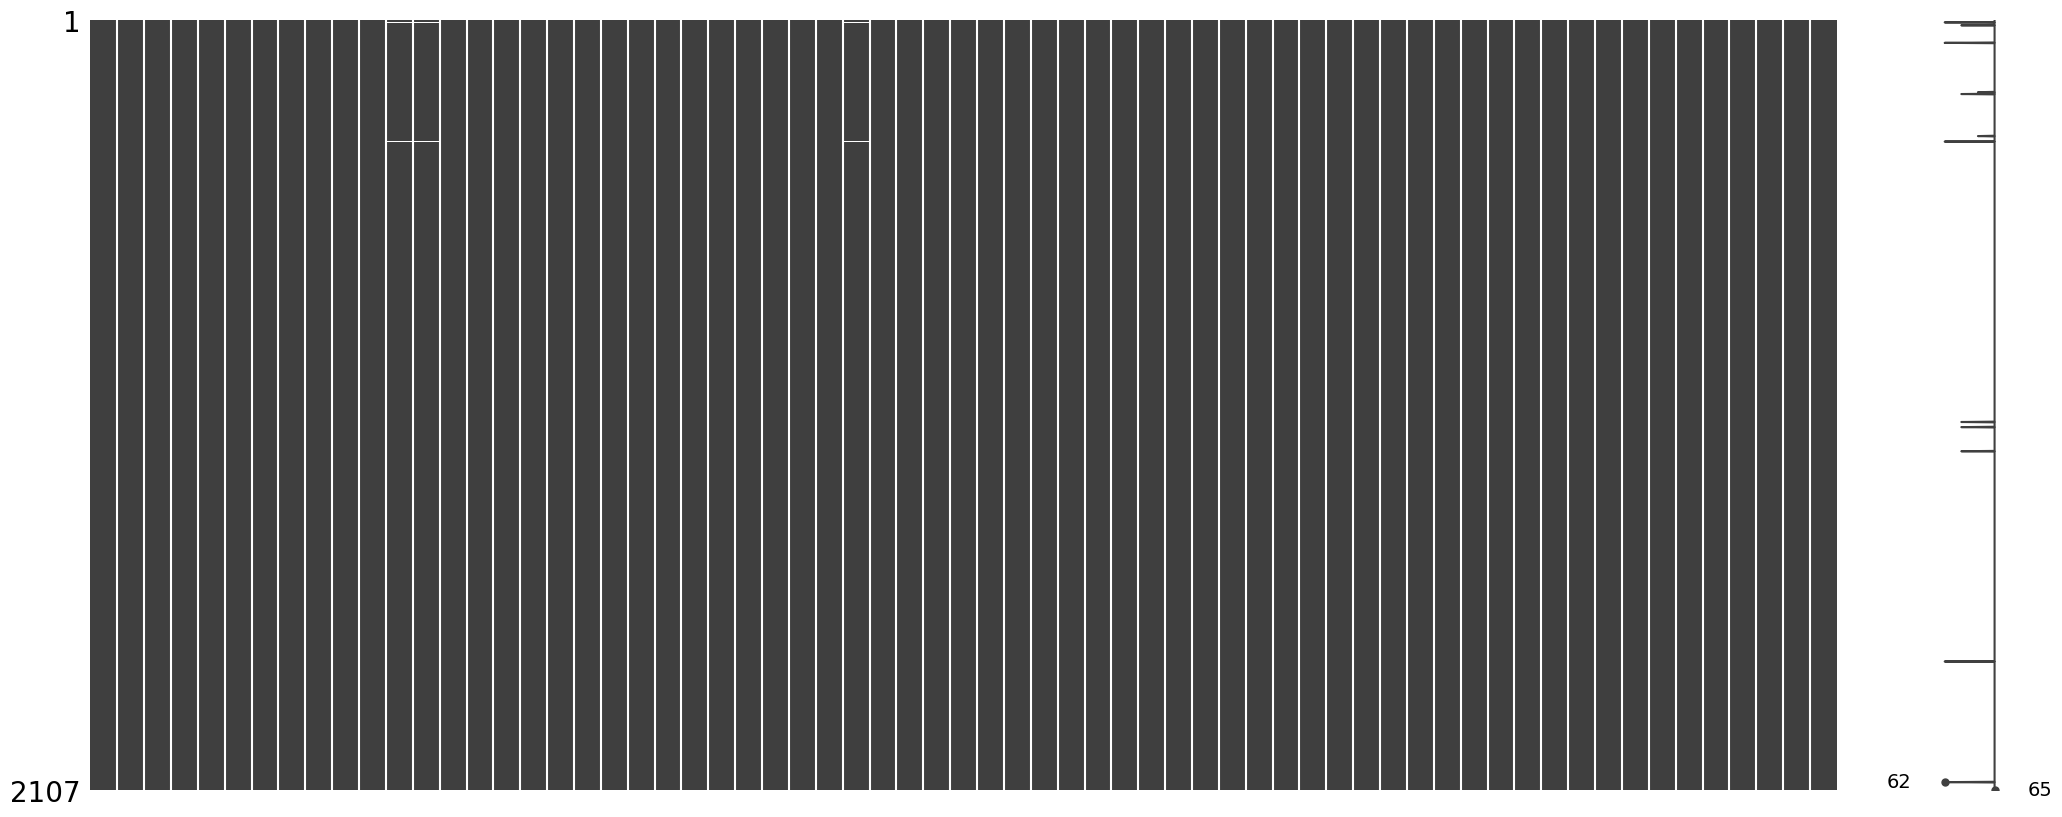

In [27]:
# Visualize missing values in each column
msno.matrix(abt_df01)

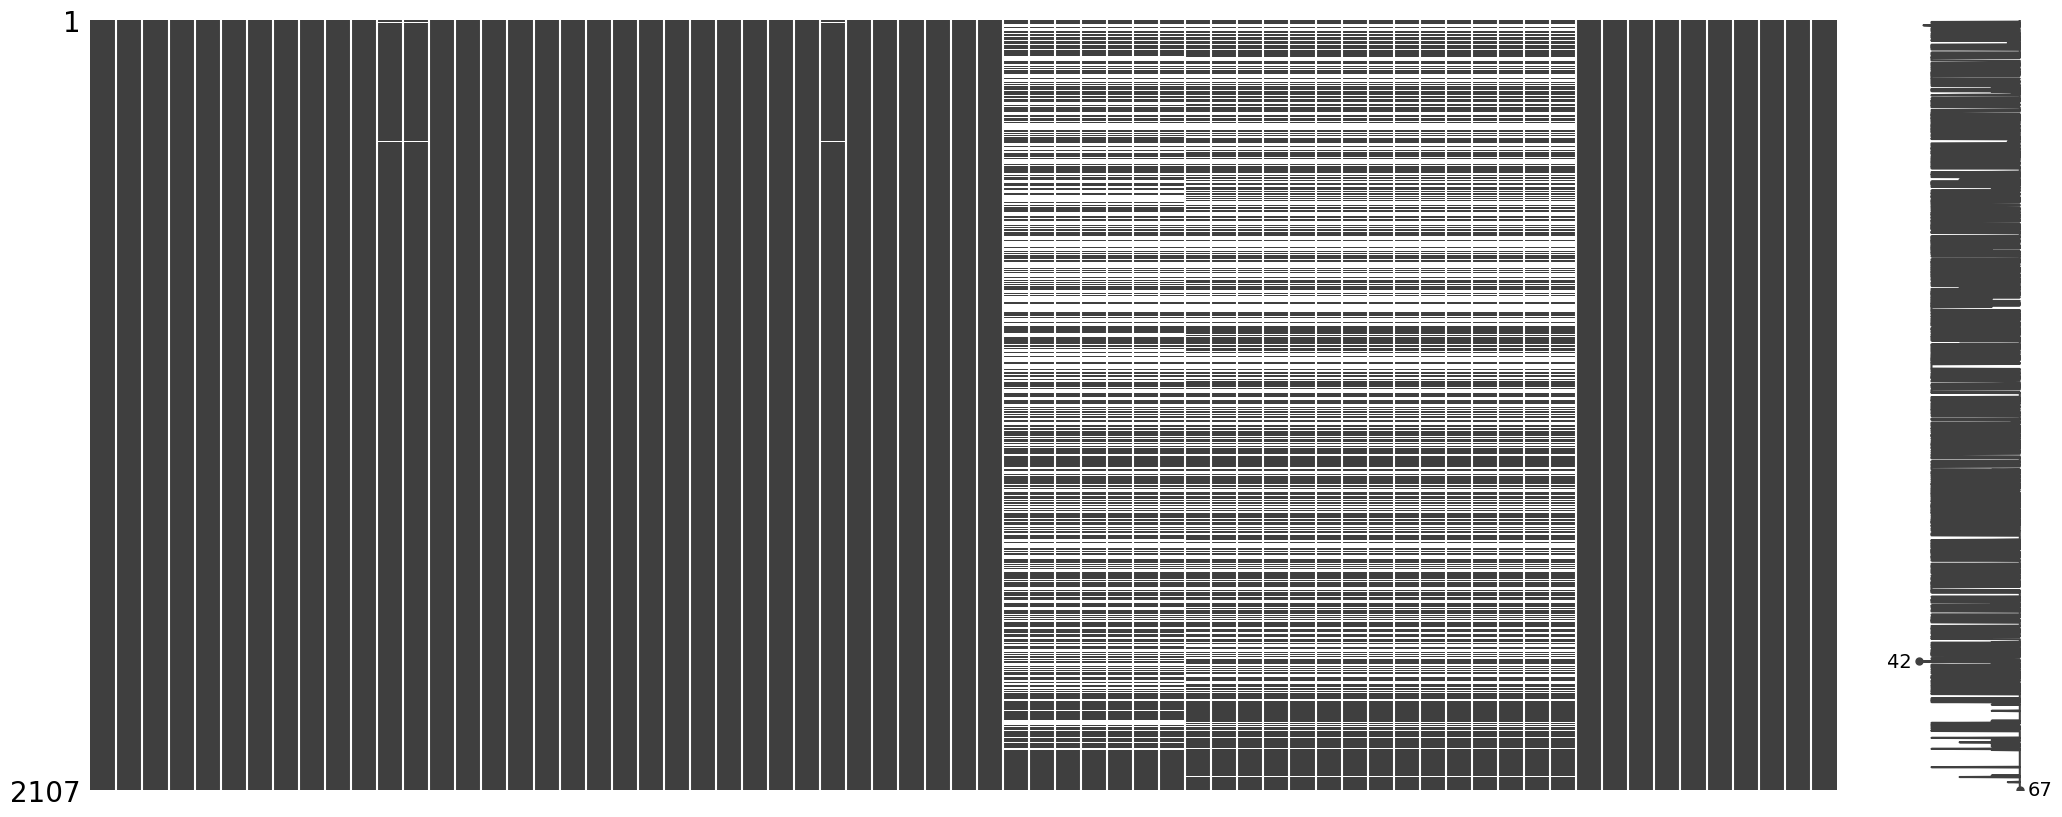

In [28]:
# Visualize missing values in each column
msno.matrix(abt_df02)

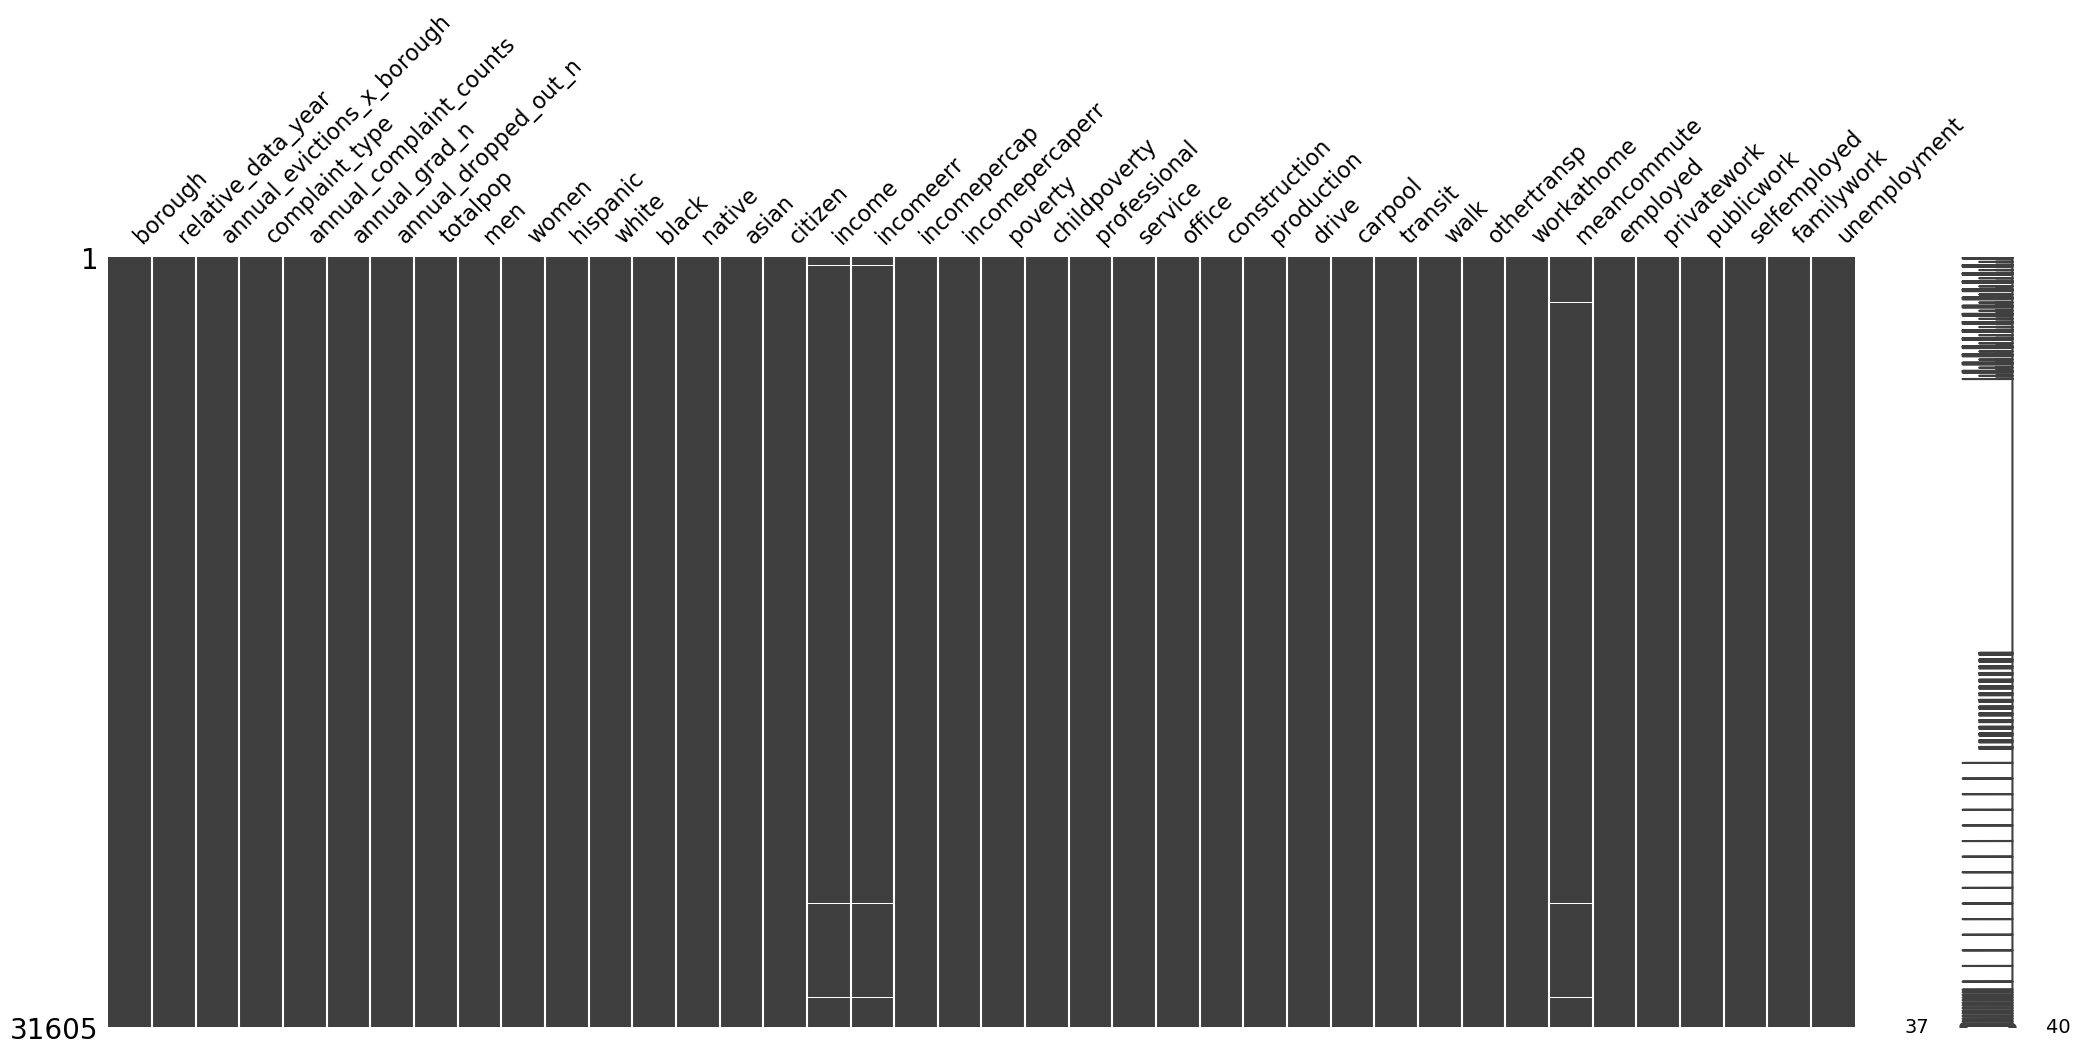

In [29]:
# Visualize missing values in each column
msno.matrix(abt_df03)

In [30]:
# Remove any features for which the number of null vals exceed a threshold--
#-- (5% of total N)
abt_df02_null_summ01 = pd.DataFrame(abt_df02.isnull().sum(),
                                        columns=['null_count'])

abt_df02_null_summ02 = abt_df02_null_summ01.loc[(abt_df02_null_summ01['null_count'] != 0)].sort_values('null_count',
                                                                                                                   ascending=False)
abt_df02_null_summ03 = abt_df02_null_summ02.reset_index()
print(abt_df02_null_summ03)

abt_df02_null_summ04 = abt_df02_null_summ03.loc[abt_df02_null_summ03['null_count'] > (len(abt_df02)*.05)]
print('\n', abt_df02_null_summ04)

abt_df02_null_summ04_remove_lst01 = list(abt_df02_null_summ04['index'])
print('\n', abt_df02_null_summ04_remove_lst01)

                 index  null_count
0                 2017         857
1                 2018         857
2                 2019         857
3                 2020         857
4                 2021         857
5                 2022         857
6                 2023         857
7     2017 - VIOLATION         815
8        2019 - FELONY         815
9   2021 - MISDEMEANOR         815
10       2021 - FELONY         815
11    2020 - VIOLATION         815
12  2020 - MISDEMEANOR         815
13       2020 - FELONY         815
14    2019 - VIOLATION         815
15  2019 - MISDEMEANOR         815
16    2021 - VIOLATION         815
17    2018 - VIOLATION         815
18  2018 - MISDEMEANOR         815
19       2018 - FELONY         815
20  2017 - MISDEMEANOR         815
21       2017 - FELONY         815
22           incomeerr          10
23              income          10
24         meancommute           7

                  index  null_count
0                 2017         857
1                 

### Create pipeline for One Hot Encoding 

In [31]:
'''Setup pipelne citation:
OpenAI. (2021). ChatGPT [Computer software]. https://openai.com/'''

print(abt_df03.shape)
display(abt_df03.head(11))

# Define a ColumnTransformer to apply the OneHotEncoder to the selected columns
cols_to_encode = ['borough',
                  'relative_data_year',
                  'complaint_type']

ct = ColumnTransformer(transformers=[('encoder',
                                      OneHotEncoder(),
                                      cols_to_encode)],
                       remainder='passthrough'
)

# Define a Pipeline to apply the ColumnTransformer
abt_pipe = Pipeline(steps=[('preprocessor',
                            ct)])

# Fit and transform the Pipeline to one-hot encode the selected columns
abt_encoded_df01 = pd.DataFrame(abt_pipe.fit_transform(abt_df03))

# Get the names of the one-hot encoded columns from the OneHotEncoder object
encoder = abt_pipe.named_steps['preprocessor'].named_transformers_['encoder']
print(encoder)

encoded_cols = encoder.get_feature_names(cols_to_encode)
print(encoded_cols)

# Get the names of the non-encoded columns by removing the columns that were encoded
non_encoded_cols = [col for col in abt_df03.columns if col not in cols_to_encode]
print(non_encoded_cols)

# Concatenate the one-hot encoded columns with the non-encoded columns to obtain the new DataFrame with the desired column names
abt_encoded_df01.columns = list(encoded_cols) + non_encoded_cols
print(abt_encoded_df01.head(11))

display(abt_encoded_df01.head(11))

(31605, 40)


,borough,relative_data_year,annual_evictions_x_borough,complaint_type,annual_complaint_counts,annual_grad_n,annual_dropped_out_n,totalpop,men,women,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,bronx,-4,7140,FELONY,589,17130.0,2833.0,5403,2659,2744,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
1,bronx,-4,7140,FELONY,589,17130.0,2833.0,5915,2896,3019,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
2,bronx,-4,7140,FELONY,589,17130.0,2833.0,5879,2558,3321,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
3,bronx,-4,7140,FELONY,589,17130.0,2833.0,2591,1206,1385,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
4,bronx,-4,7140,FELONY,589,17130.0,2833.0,8516,3301,5215,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
5,bronx,-4,7140,FELONY,589,17130.0,2833.0,4774,2130,2644,...,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
6,bronx,-4,7140,FELONY,589,17130.0,2833.0,150,109,41,...,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
7,bronx,-4,7140,FELONY,589,17130.0,2833.0,5355,2338,3017,...,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
8,bronx,-4,7140,FELONY,589,17130.0,2833.0,3016,1375,1641,...,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2
9,bronx,-4,7140,FELONY,589,17130.0,2833.0,4778,2427,2351,...,7.1,0.7,0.5,44.0,1559,75.0,14.0,11.0,0.0,10.6


OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)
['borough_bronx' 'borough_brooklyn' 'borough_manhattan' 'borough_queens'
 'borough_staten island' 'relative_data_year_-4' 'relative_data_year_-3'
 'relative_data_year_-2' 'relative_data_year_-1' 'relative_data_year_0'
 'complaint_type_FELONY' 'complaint_type_MISDEMEANOR'
 'complaint_type_VIOLATION']
['annual_evictions_x_borough', 'annual_complaint_counts', 'annual_grad_n', 'annual_dropped_out_n', 'totalpop', 'men', 'women', 'hispanic', 'white', 'black', 'native', 'asian', 'citizen', 'income', 'incomeerr', 'incomepercap', 'incomepercaperr', 'poverty', 'childpoverty', 'professional', 'service', 'office', 'construction', 'production', 'drive', 'carpool', 'transit', 'walk', 'othertransp', 'workathome', 'meancommute', 'employed', 'privatework', 'publicwork', 'selfemployed', 'familywork', 'unemployment']
    borough_bronx  borough_brooklyn  borough_manhattan  borough_

,borough_bronx,borough_brooklyn,borough_manhattan,borough_queens,borough_staten island,relative_data_year_-4,relative_data_year_-3,relative_data_year_-2,relative_data_year_-1,relative_data_year_0,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.9,0.0,0.0,43.0,2308.0,80.8,16.2,2.9,0.0,7.7
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.4,0.5,2.1,45.0,2675.0,71.7,25.3,2.5,0.6,9.5
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,8.6,1.6,1.7,38.8,2120.0,75.0,21.3,3.8,0.0,8.7
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,2.4,6.2,45.4,1083.0,76.8,15.5,7.7,0.0,19.2
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4.3,1.0,0.0,46.0,2508.0,71.0,21.3,7.7,0.0,17.2
5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,14.0,1.5,4.1,42.7,1191.0,74.2,16.1,9.7,0.0,18.9
6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,113.0,62.8,37.2,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,17.7,1.8,2.7,35.5,1691.0,85.1,8.3,6.1,0.5,9.4
8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,18.0,0.0,1.6,42.8,1102.0,86.9,8.5,4.5,0.0,15.2
9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7.1,0.7,0.5,44.0,1559.0,75.0,14.0,11.0,0.0,10.6


### Save ABT to S3

In [32]:
s3_abt_csv_path = f"s3://{def_bucket}/team_8_data/abt/abt_encoded_df01.csv"
abt_encoded_df01.to_csv(s3_abt_csv_path, index=False, header=True)

## Show the Tables

In [33]:
show_tbl_stmnt = f"SHOW TABLES in {database_name}"

In [34]:
df_tables = pd.read_sql(show_tbl_stmnt,
                        conn)

df_tables.head(17)

,tab_name
0,census
1,census_block
2,crime
3,crime_pqt
4,evictions
5,grad_outcomes
6,hs_info
7,jobs


## Review the New Athena Table in the Glue Catalog

In [35]:
display(
    HTML(
        f'<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={region}#">AWS Glue Catalog</a></b>'
    )
)

## Store Variables for the Next Notebooks

In [36]:
%store

Stored variables and their in-db values:
balance_dataset                                       -> True
balanced_bias_data_jsonlines_s3_uri                   -> 's3://sagemaker-us-east-1-657724983756/bias-detect
balanced_bias_data_s3_uri                             -> 's3://sagemaker-us-east-1-657724983756/bias-detect
bias_data_s3_uri                                      -> 's3://sagemaker-us-east-1-657724983756/bias-detect
experiment_name                                       -> 'Amazon-Customer-Reviews-BERT-Experiment-168013737
feature_group_name                                    -> 'reviews-feature-group-1680137375'
feature_store_offline_prefix                          -> 'reviews-feature-store-1680137375'
ingest_create_athena_db_passed                        -> True
ingest_create_athena_table_parquet_passed             -> True
ingest_create_athena_table_tsv_passed                 -> True
max_seq_length                                        -> 64
processed_test_data_s3_uri         

## Release Resources

In [37]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [38]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>